<a href="https://colab.research.google.com/github/Korniev/Machine-Learning-projects/blob/main/image_classification_tiny_imagenet_efficientB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries:

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import zipfile
import os
import shutil

Upload the file to Google Colab and list the uploaded files to verify:

In [6]:
from google.colab import files
uploaded = files.upload()

for filename in uploaded.keys():
    print(f'Uploaded file: {filename}')

Saving archive.zip to archive.zip
Uploaded file: archive.zip


Extract the uploaded file and Assuming the uploaded file is named 'archive.zip':

In [7]:
zip_path = '/content/archive.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

Verify the extracted files:

In [8]:
!ls /content/tiny-imagenet-200

test  train  val  wnids.txt  words.txt


Let's make some manipulations for dataset

In [9]:
val_dir = '/content/tiny-imagenet-200/val'
val_images_dir = os.path.join(val_dir, 'images')
val_annotations_file = os.path.join(val_dir, 'val_annotations.txt')


Create subdirectories for each class and then remove the now-empty images directory:

In [10]:
with open(val_annotations_file, 'r') as f:
    for line in f.readlines():
        parts = line.strip().split('\t')
        image_name = parts[0]
        class_name = parts[1]

        class_dir = os.path.join(val_dir, class_name)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        source = os.path.join(val_images_dir, image_name)
        destination = os.path.join(class_dir, image_name)
        shutil.move(source, destination)

shutil.rmtree(val_images_dir)

Define paths:

In [11]:
train_dir = './tiny-imagenet-200/train'
val_dir = './tiny-imagenet-200/val'

Define image data generators with enhanced data augmentation:

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)


Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


Load the pre-trained EfficientNetB3 model:

In [13]:
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Add custom layers on top:

In [14]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(200, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

Fine-tune the entire model by unfreeze the last 100 layers:

In [15]:
for layer in base_model.layers[-100:]:
    layer.trainable = True

Compile the model:

In [16]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Define a learning rate scheduler and callbacks:

In [17]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

lr_scheduler = LearningRateScheduler(scheduler)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.000001)

Train the model:

In [18]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, lr_scheduler]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 381s 85ms/step - accuracy: 0.0464 - loss: 15.4556 - val_accuracy: 0.3278 - val_loss: 7.1360 - learning_rate: 1.0000e-04
Epoch 2/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 256s 82ms/step - accuracy: 0.2401 - loss: 6.7960 - val_accuracy: 0.4305 - val_loss: 3.9924 - learning_rate: 1.0000e-04
Epoch 3/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 256s 80ms/step - accuracy: 0.3413 - loss: 4.1173 - val_accuracy: 0.4728 - val_loss: 3.0772 - learning_rate: 1.0000e-04
Epoch 4/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 256s 82ms/step - accuracy: 0.3887 - loss: 3.2824 - val_accuracy: 0.4950 - val_loss: 2.7391 - learning_rate: 1.0000e-04
Epoch 5/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 256s 80ms/step - accuracy: 0.4283 - loss: 2.9064 - val_accuracy: 0.5097 - val_loss: 2.6449 - learning_rate: 1.0000e-04
Epoch 6/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 262s 84ms/step - accuracy: 0.4496 - loss: 2.7235 - val_accuracy: 0.5190 - val_loss: 2.5658 - learning_rate: 1.0000e-04
Epoch 7/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 25

Let's evaluate the model:

In [19]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_accuracy}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.5796 - loss: 2.0800
Validation Accuracy: 0.5813000202178955


**Let's visualize prediction:**

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model

In [28]:
# Create a mapping from synset IDs to human-readable labels
def load_class_labels(filepath):
    class_labels = {}
    with open(filepath, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split('\t')
            synset_id = parts[0]
            label = parts[1]
            class_labels[synset_id] = label
    return class_labels

class_labels = load_class_labels('/content/tiny-imagenet-200/words.txt')


Define a function to load, preprocess, and predict an image:

In [29]:
def predict_and_visualize(image_path, model, class_indices, class_labels):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(64, 64))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make predictions
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]

    # Decode the prediction
    class_labels_reverse = {v: k for k, v in class_indices.items()}
    predicted_synset_id = class_labels_reverse[predicted_class_index]
    predicted_class_label = class_labels[predicted_synset_id]

    # Print prediction probabilities for debugging
    print(f"Predictions: {predictions}")
    print(f"Predicted class index: {predicted_class_index}")
    print(f"Predicted synset ID: {predicted_synset_id}")
    print(f"Predicted class label: {predicted_class_label}")

    # Visualize the result
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class_label} (Class {predicted_class_index})')
    plt.axis('off')
    plt.show()

Assume 'class_indices' is a dictionary mapping class names to their index:

In [30]:
class_indices = train_generator.class_indices

Test the function with an example image:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predictions: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]]
Predicted class index: 35
Predicted synset ID: n02132136
Predicted class label: brown bear, bruin, Ursus arctos


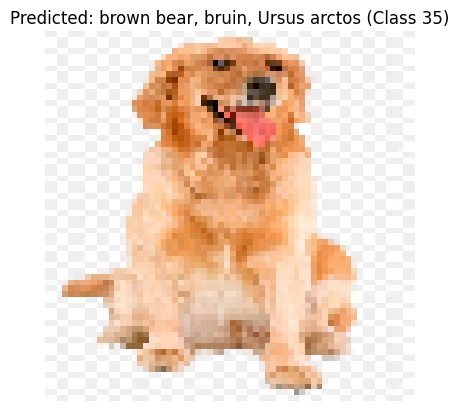

In [37]:
predict_and_visualize('/content/1.png', model, class_indices, class_labels)